<a href="https://colab.research.google.com/github/RibhuAgarwal/StockAnalyzer/blob/main/Stock_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Latest Closing Price: 74.92
Predicted Closing Price for Next Month: 74.87


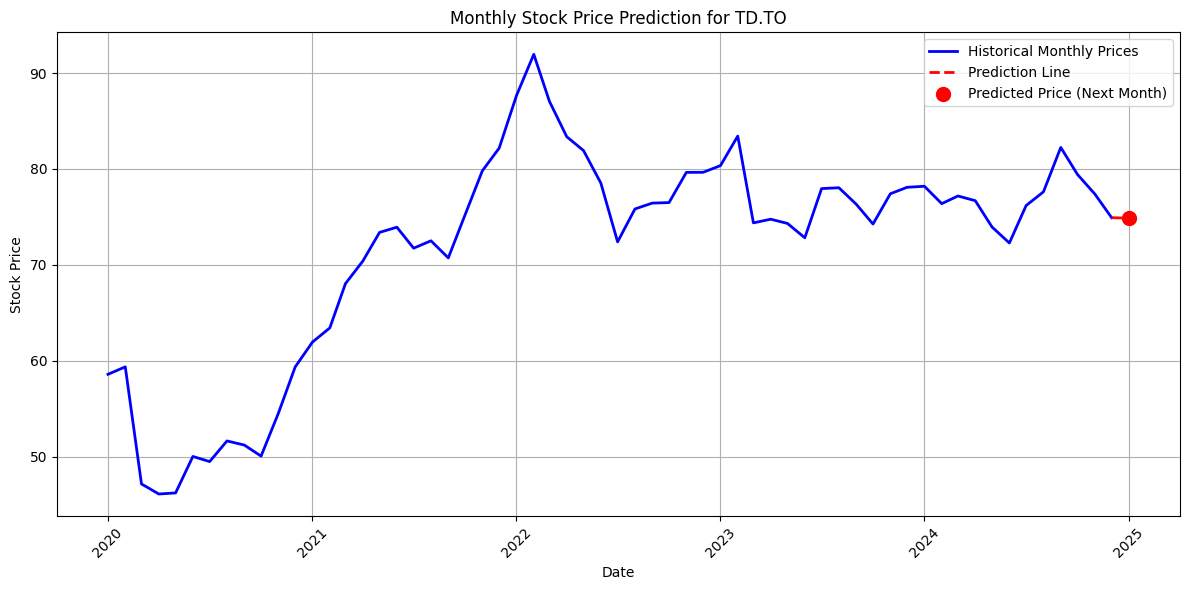

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Step 1: Fetch and preprocess data
stock_symbol = "TD.TO"
start_date = "2020-01-01"
end_date = "2025-01-22"
data = yf.download(stock_symbol, start=start_date, end=end_date)
data.reset_index(inplace=True)
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Resample data to monthly frequency
data = data.resample('MS').mean()  # Use 'MS' for Month Start
data.reset_index(inplace=True)

# Create target column (next month's price)
data['Next_Month_Close'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Features (X) and target (y)
X = np.array(data[['Close']])
y = np.array(data['Next_Month_Close'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict next month's price
latest_close_price = data['Close'].iloc[-1].item()  # Convert to scalar
next_month_prediction = model.predict(np.array([[latest_close_price]])).item()  # Convert to scalar

print(f"Latest Closing Price: {latest_close_price:.2f}")
print(f"Predicted Closing Price for Next Month: {next_month_prediction:.2f}")

# Step 2: Visualize the data and prediction
plt.figure(figsize=(12, 6))

# Plot historical prices
plt.plot(data['Date'], data['Close'], label="Historical Monthly Prices", color="blue", linewidth=2)

# Extend the graph to include the prediction
future_date = data['Date'].iloc[-1] + pd.DateOffset(months=1)  # Next month's date
plt.plot([data['Date'].iloc[-1], future_date],
         [latest_close_price, next_month_prediction],
         label="Prediction Line", color="red", linestyle="--", linewidth=2)

# Mark the predicted point
plt.scatter(future_date, next_month_prediction, color="red", label="Predicted Price (Next Month)", s=100, zorder=5)

# Format the graph
plt.title(f"Monthly Stock Price Prediction for {stock_symbol}")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the graph
plt.show()


[*********************100%***********************]  1 of 1 completed


Latest Closing Price: 81.86
20-Day Moving Average: 77.97
50-Day Moving Average: 76.93
Recommendation: STRONG BUY


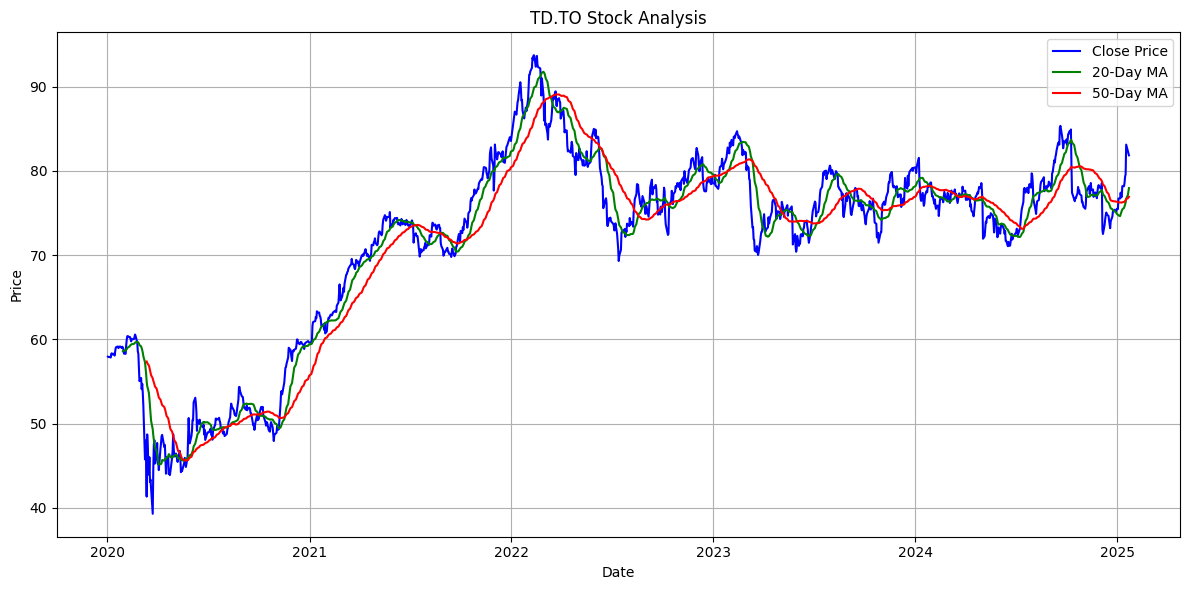

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch stock data
stock_symbol = "TD.TO"
data = yf.download(stock_symbol, start="2020-01-01", end="2025-01-23")

# Calculate Moving Averages
data['20_MA'] = data['Close'].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close'].rolling(window=50).mean()  # 50-day moving average

# Ensure the latest values are scalars
latest_close = data['Close'].iloc[-1].item()  # Extract scalar value
latest_20_ma = data['20_MA'].iloc[-1].item()  # Extract scalar value
latest_50_ma = data['50_MA'].iloc[-1].item()  # Extract scalar value

# Decision based on moving averages
if latest_20_ma > latest_50_ma and latest_close > latest_20_ma:
    decision = "STRONG BUY"
elif latest_20_ma < latest_50_ma and latest_close < latest_20_ma:
    decision = "STRONG SELL"
else:
    decision = "HOLD"

# Print the decision
print(f"Latest Closing Price: {latest_close:.2f}")
print(f"20-Day Moving Average: {latest_20_ma:.2f}")
print(f"50-Day Moving Average: {latest_50_ma:.2f}")
print(f"Recommendation: {decision}")

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['20_MA'], label='20-Day MA', color='green')
plt.plot(data['50_MA'], label='50-Day MA', color='red')
plt.title(f"{stock_symbol} Stock Analysis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


        Date  Close_TD.TO  High_TD.TO  Low_TD.TO  Open_TD.TO  Volume_TD.TO  \
0 2020-01-02    57.946800   57.994159  57.560069   57.781058       2207900   
1 2020-01-03    57.899452   57.946805  57.544292   57.678463       3472900   
2 2020-01-06    57.907349   57.986273  57.583753   57.615324       8359000   
3 2020-01-07    57.844200   58.175684  57.788953   58.017836       3622600   
4 2020-01-08    58.294060   58.562402  57.796834   57.867864       6465500   

   20_MA  50_MA  
0    NaN    NaN  
1    NaN    NaN  
2    NaN    NaN  
3    NaN    NaN  
4    NaN    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1255 non-null   datetime64[ns]
 1   Close_TD.TO   1255 non-null   float64       
 2   High_TD.TO    1255 non-null   float64       
 3   Low_TD.TO     1255 non-null   float64       
 4   Open_TD.TO  

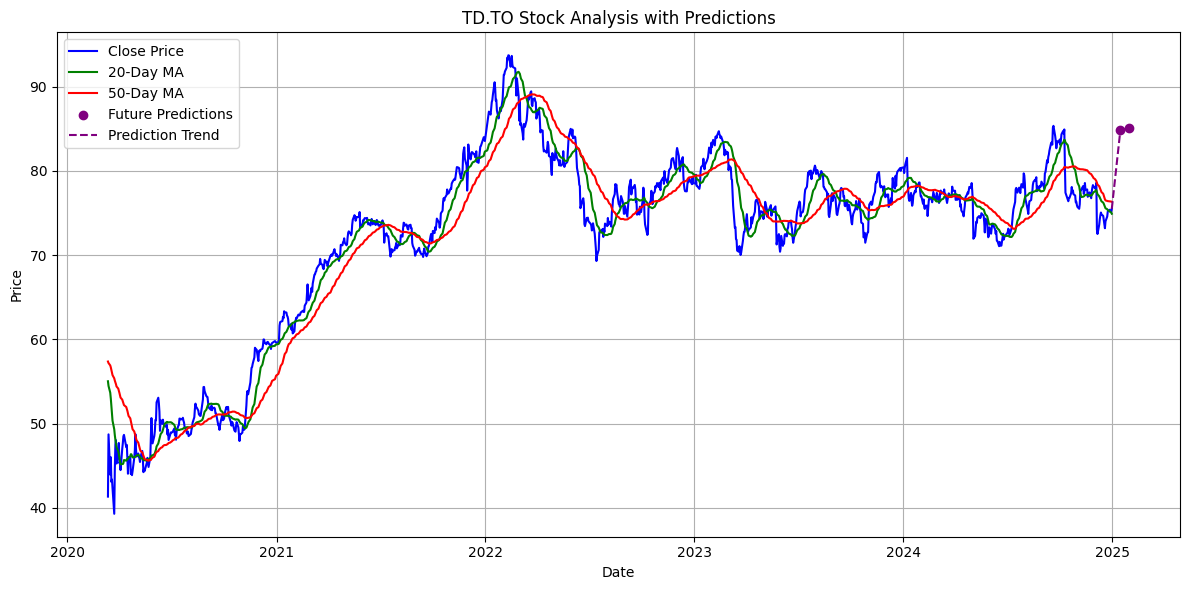

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Fetch stock data
stock_symbol = "TD.TO"  # Replace with your desired stock symbol
data = yf.download(stock_symbol, start="2020-01-01", end="2025-01-01")

# Reset the index to ensure 'Date' is a column
data.reset_index(inplace=True)

# Flatten multi-level column names
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

# Calculate Moving Averages
data['20_MA'] = data['Close_TD.TO'].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close_TD.TO'].rolling(window=50).mean()  # 50-day moving average

# Debug: Check if columns are present
print(data.head())
print(data.info())

# Handle Missing Values
data = data.dropna(subset=['20_MA', '50_MA'])  # Drop rows with NaN in moving averages

# Ensure the latest values are properly extracted as scalars
latest_close = data['Close_TD.TO'].iloc[-1]  # Extract scalar value
latest_20_ma = data['20_MA'].iloc[-1]  # Extract scalar value
latest_50_ma = data['50_MA'].iloc[-1]  # Extract scalar value

# Handle NaN values in moving averages
if pd.isna(latest_20_ma) or pd.isna(latest_50_ma):
    print("Not enough data to calculate moving averages. Exiting...")
    exit()

# Decision based on moving averages
if latest_20_ma > latest_50_ma and latest_close > latest_20_ma:
    decision = "STRONG BUY"
elif latest_20_ma < latest_50_ma and latest_close < latest_20_ma:
    decision = "STRONG SELL"
else:
    decision = "HOLD"

# Train a model for future price prediction
data['Day'] = (data['Date'] - data['Date'].min()).dt.days  # Convert dates to days for regression
X = data[['Day']]
y = data['Close_TD.TO']

# Train-test split (to verify accuracy if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict prices for 15 days and 30 days from today
future_days = [(data['Day'].iloc[-1] + 15), (data['Day'].iloc[-1] + 30)]
future_prices = model.predict(np.array(future_days).reshape(-1, 1))

# Extract scalar values
price_15_days = future_prices[0].item()  # Convert to scalar
price_30_days = future_prices[1].item()  # Convert to scalar

# Print Results
print(f"Latest Closing Price: {latest_close:.2f}")
print(f"20-Day Moving Average: {latest_20_ma:.2f}")
print(f"50-Day Moving Average: {latest_50_ma:.2f}")
print(f"Recommendation: {decision}")
print(f"Predicted Price after 15 Days: {price_15_days:.2f}")
print(f"Predicted Price after 30 Days: {price_30_days:.2f}")

# Plot the data
plt.figure(figsize=(12, 6))

# Historical Prices
plt.plot(data['Date'], data['Close_TD.TO'], label='Close Price', color='blue')

# Moving Averages
plt.plot(data['Date'], data['20_MA'], label='20-Day MA', color='green')
plt.plot(data['Date'], data['50_MA'], label='50-Day MA', color='red')

# Plot future predictions
future_dates = [data['Date'].iloc[-1] + pd.Timedelta(days=15), data['Date'].iloc[-1] + pd.Timedelta(days=30)]
plt.scatter(future_dates, [price_15_days, price_30_days], color='purple', label="Future Predictions", zorder=5)
plt.plot([data['Date'].iloc[-1], future_dates[0], future_dates[1]],
         [latest_close, price_15_days, price_30_days],
         color='purple', linestyle='--', label="Prediction Trend")

# Format the plot
plt.title(f"{stock_symbol} Stock Analysis with Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


[*********************100%***********************]  1 of 1 completed


Enter the number of shares you own: 7
Enter the price at which you bought the stock: 74.57
Your total investment: $521.99
Your portfolio value: $574.77
Your gain/loss: $52.78 (10.11%)
Recommendation: HOLD


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


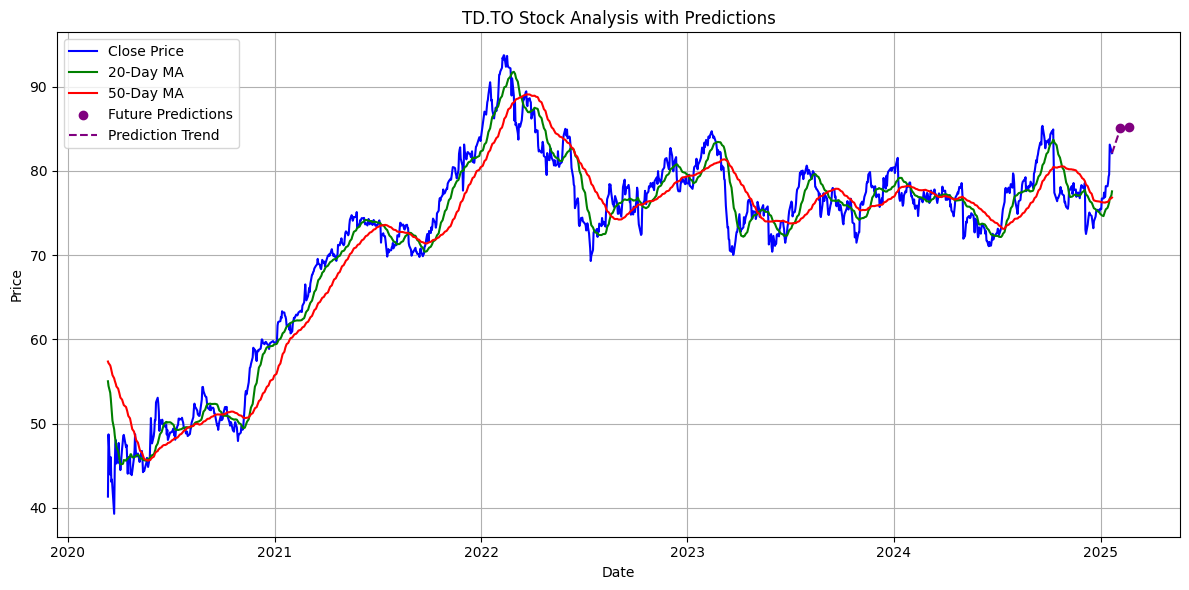

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Fetch stock data
stock_symbol = "TD.TO"  # Replace with your desired stock symbol
data = yf.download(stock_symbol, start="2020-01-01", end="2025-01-22")

# Reset the index to ensure 'Date' is a column
data.reset_index(inplace=True)

# Flatten multi-level column names
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

# Calculate Moving Averages
data['20_MA'] = data['Close_TD.TO'].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close_TD.TO'].rolling(window=50).mean()  # 50-day moving average

# Drop rows with NaN in moving averages
data = data.dropna(subset=['20_MA', '50_MA'])

# Ensure the latest values are properly extracted as scalars
latest_close = data['Close_TD.TO'].iloc[-1]  # Extract scalar value
latest_20_ma = data['20_MA'].iloc[-1]  # Extract scalar value
latest_50_ma = data['50_MA'].iloc[-1]  # Extract scalar value

# Handle NaN values in moving averages
if pd.isna(latest_20_ma) or pd.isna(latest_50_ma):
    print("Not enough data to calculate moving averages. Exiting...")
    exit()

# Ask user for their stock holdings
number_of_shares = float(input("Enter the number of shares you own: "))
purchase_price = float(input("Enter the price at which you bought the stock: "))

# Calculate portfolio value and gain/loss
portfolio_value = number_of_shares * latest_close
total_investment = number_of_shares * purchase_price
gain_loss = portfolio_value - total_investment
gain_loss_percentage = (gain_loss / total_investment) * 100

# Decision based on moving averages and user's holdings
if latest_20_ma > latest_50_ma and latest_close > latest_20_ma:
    decision = "BUY MORE" if gain_loss_percentage < 10 else "HOLD"
elif latest_20_ma < latest_50_ma and latest_close < latest_20_ma:
    decision = "SELL" if gain_loss_percentage > 10 else "HOLD"
else:
    decision = "HOLD"

# Print Results
print(f"Your total investment: ${total_investment:.2f}")
print(f"Your portfolio value: ${portfolio_value:.2f}")
print(f"Your gain/loss: ${gain_loss:.2f} ({gain_loss_percentage:.2f}%)")
print(f"Recommendation: {decision}")

# Train a model for future price prediction
data['Day'] = (data['Date'] - data['Date'].min()).dt.days  # Convert dates to days for regression
X = data[['Day']]
y = data['Close_TD.TO']

# Train-test split (to verify accuracy if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict prices for 15 days and 30 days from today
future_days = [(data['Day'].iloc[-1] + 15), (data['Day'].iloc[-1] + 30)]
future_prices = model.predict(np.array(future_days).reshape(-1, 1))

# Extract scalar values
price_15_days = future_prices[0].item()  # Convert to scalar
price_30_days = future_prices[1].item()  # Convert to scalar

# Plot the data
plt.figure(figsize=(12, 6))

# Historical Prices
plt.plot(data['Date'], data['Close_TD.TO'], label='Close Price', color='blue')

# Moving Averages
plt.plot(data['Date'], data['20_MA'], label='20-Day MA', color='green')
plt.plot(data['Date'], data['50_MA'], label='50-Day MA', color='red')

# Plot future predictions
future_dates = [data['Date'].iloc[-1] + pd.Timedelta(days=15), data['Date'].iloc[-1] + pd.Timedelta(days=30)]
plt.scatter(future_dates, [price_15_days, price_30_days], color='purple', label="Future Predictions", zorder=5)
plt.plot([data['Date'].iloc[-1], future_dates[0], future_dates[1]],
         [latest_close, price_15_days, price_30_days],
         color='purple', linestyle='--', label="Prediction Trend")

# Format the plot
plt.title(f"{stock_symbol} Stock Analysis with Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


Enter the stock symbol (e.g., AAPL, TD.TO): XGD.TO


[*********************100%***********************]  1 of 1 completed


Enter the number of shares you own: 20
Enter the price at which you bought the stock: 22.90


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



===== Analysis for XGD.TO =====
Latest Closing Price: $21.08
20-Day Moving Average: $22.01
50-Day Moving Average: $22.70
Your Total Investment: $458.00
Your Portfolio Value: $421.60
Your Gain/Loss: $-36.40 (-7.95%)
Predicted Price after 15 Days: $19.13
Predicted Price after 30 Days: $19.14
Recommendation: HOLD


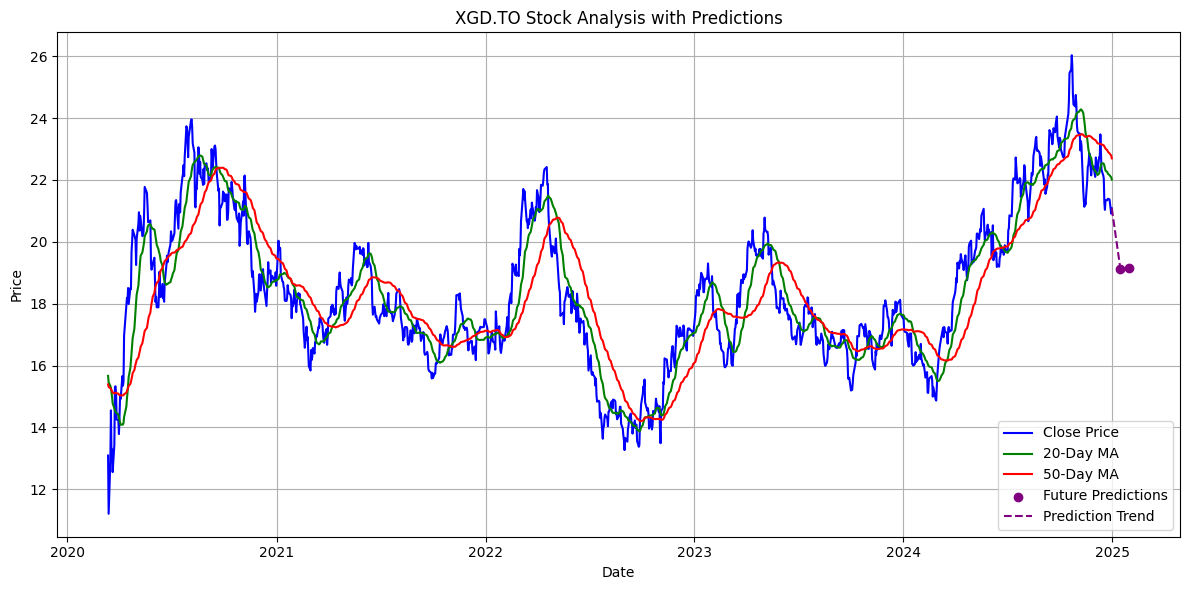

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Ask user for stock symbol
stock_symbol = input("Enter the stock symbol (e.g., AAPL, TD.TO): ")

# Fetch stock data
data = yf.download(stock_symbol, start="2020-01-01", end="2025-01-01")

# Reset the index to ensure 'Date' is a column
data.reset_index(inplace=True)

# Flatten multi-level column names
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

# Calculate Moving Averages
data['20_MA'] = data['Close_' + stock_symbol].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close_' + stock_symbol].rolling(window=50).mean()  # 50-day moving average

# Drop rows with NaN in moving averages
data = data.dropna(subset=['20_MA', '50_MA'])

# Ensure the latest values are properly extracted as scalars
latest_close = data['Close_' + stock_symbol].iloc[-1]  # Extract scalar value
latest_20_ma = data['20_MA'].iloc[-1]  # Extract scalar value
latest_50_ma = data['50_MA'].iloc[-1]  # Extract scalar value

# Handle NaN values in moving averages
if pd.isna(latest_20_ma) or pd.isna(latest_50_ma):
    print("Not enough data to calculate moving averages. Exiting...")
    exit()

# Ask user for their stock holdings
number_of_shares = float(input("Enter the number of shares you own: "))
purchase_price = float(input("Enter the price at which you bought the stock: "))

# Calculate portfolio value and gain/loss
portfolio_value = number_of_shares * latest_close
total_investment = number_of_shares * purchase_price
gain_loss = portfolio_value - total_investment
gain_loss_percentage = (gain_loss / total_investment) * 100

# Decision based on moving averages and user's holdings
if latest_20_ma > latest_50_ma and latest_close > latest_20_ma:
    decision = "BUY MORE" if gain_loss_percentage < 10 else "HOLD"
elif latest_20_ma < latest_50_ma and latest_close < latest_20_ma:
    decision = "SELL" if gain_loss_percentage > 10 else "HOLD"
else:
    decision = "HOLD"

# Train a model for future price prediction
data['Day'] = (data['Date'] - data['Date'].min()).dt.days  # Convert dates to days for regression
X = data[['Day']]
y = data['Close_' + stock_symbol]

# Train-test split (to verify accuracy if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict prices for 15 days and 30 days from today
future_days = [(data['Day'].iloc[-1] + 15), (data['Day'].iloc[-1] + 30)]
future_prices = model.predict(np.array(future_days).reshape(-1, 1))

# Extract scalar values
price_15_days = future_prices[0].item()  # Convert to scalar
price_30_days = future_prices[1].item()  # Convert to scalar

# Print Results
print(f"\n===== Analysis for {stock_symbol} =====")
print(f"Latest Closing Price: ${latest_close:.2f}")
print(f"20-Day Moving Average: ${latest_20_ma:.2f}")
print(f"50-Day Moving Average: ${latest_50_ma:.2f}")
print(f"Your Total Investment: ${total_investment:.2f}")
print(f"Your Portfolio Value: ${portfolio_value:.2f}")
print(f"Your Gain/Loss: ${gain_loss:.2f} ({gain_loss_percentage:.2f}%)")
print(f"Predicted Price after 15 Days: ${price_15_days:.2f}")
print(f"Predicted Price after 30 Days: ${price_30_days:.2f}")
print(f"Recommendation: {decision}")

# Plot the data
plt.figure(figsize=(12, 6))

# Historical Prices
plt.plot(data['Date'], data['Close_' + stock_symbol], label='Close Price', color='blue')

# Moving Averages
plt.plot(data['Date'], data['20_MA'], label='20-Day MA', color='green')
plt.plot(data['Date'], data['50_MA'], label='50-Day MA', color='red')

# Plot future predictions
future_dates = [data['Date'].iloc[-1] + pd.Timedelta(days=15), data['Date'].iloc[-1] + pd.Timedelta(days=30)]
plt.scatter(future_dates, [price_15_days, price_30_days], color='purple', label="Future Predictions", zorder=5)
plt.plot([data['Date'].iloc[-1], future_dates[0], future_dates[1]],
         [latest_close, price_15_days, price_30_days],
         color='purple', linestyle='--', label="Prediction Trend")

# Format the plot
plt.title(f"{stock_symbol} Stock Analysis with Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


Enter the stock symbol (e.g., AAPL, TD.TO): XGD.TO


[*********************100%***********************]  1 of 1 completed


Model R² score (train): 0.9940125540221405
Model R² score (test): 0.9571782484013905
Enter the period you want to analyze (e.g., 3 months, 1 year): 1 month

===== Analysis for XGD.TO =====
Latest Closing Price: $21.08
20-Day Moving Average: $22.01
50-Day Moving Average: $22.70
Predicted Price for 1 month: $21.21
Recommendation: HOLD


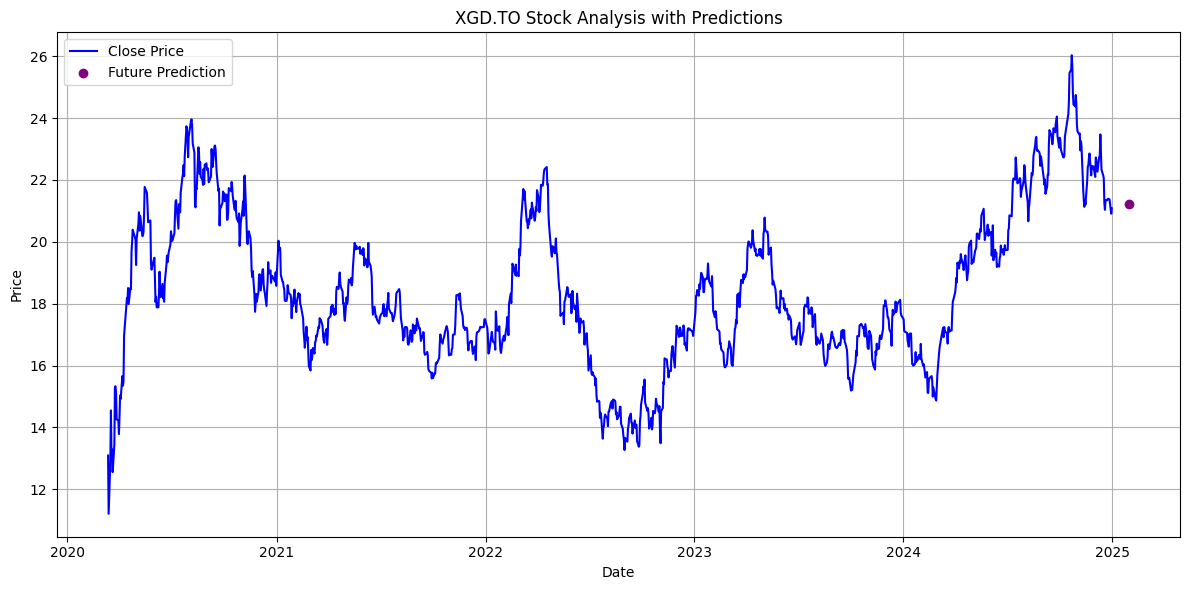

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Ask user for stock symbol
stock_symbol = input("Enter the stock symbol (e.g., AAPL, TD.TO): ").upper()

# Fetch stock data
data = yf.download(stock_symbol, start="2020-01-01", end="2025-01-01")

# Reset the index to ensure 'Date' is a column
data.reset_index(inplace=True)

# Flatten multi-level column names
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

# Feature Engineering
data['20_MA'] = data['Close_' + stock_symbol].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close_' + stock_symbol].rolling(window=50).mean()  # 50-day moving average
data['Daily_Return'] = data['Close_' + stock_symbol].pct_change()  # Daily percentage return

# Drop rows with NaN values (from rolling windows)
data = data.dropna(subset=['20_MA', '50_MA', 'Daily_Return'])

# Ensure the latest values are properly extracted
latest_close = data['Close_' + stock_symbol].iloc[-1]
latest_20_ma = data['20_MA'].iloc[-1]
latest_50_ma = data['50_MA'].iloc[-1]

# Add 'Day' feature
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Define features (X) and target (y)
X = data[['Day', '20_MA', '50_MA', 'Daily_Return']]
y = data['Close_' + stock_symbol]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
print("Model R² score (train):", model.score(X_train, y_train))
print("Model R² score (test):", model.score(X_test, y_test))

# Ask user for investment period
investment_period = input("Enter the period you want to analyze (e.g., 3 months, 1 year): ")

# Convert investment period into days
if "month" in investment_period.lower():
    months = int(investment_period.split()[0])
    future_days = months * 30
elif "year" in investment_period.lower():
    years = int(investment_period.split()[0])
    future_days = years * 365
else:
    print("Invalid period. Please enter in months or years.")
    exit()

# Prepare prediction data
future_day = pd.DataFrame({
    'Day': [data['Day'].iloc[-1] + future_days],
    '20_MA': [latest_20_ma],
    '50_MA': [latest_50_ma],
    'Daily_Return': [0]  # Assume neutral return for future
})

# Predict future price
future_price = model.predict(future_day)[0]

# Decision logic
if future_price > latest_close * 1.1:
    decision = "BUY"
elif future_price < latest_close * 0.9:
    decision = "SELL"
else:
    decision = "HOLD"

# Print results
print(f"\n===== Analysis for {stock_symbol} =====")
print(f"Latest Closing Price: ${latest_close:.2f}")
print(f"20-Day Moving Average: ${latest_20_ma:.2f}")
print(f"50-Day Moving Average: ${latest_50_ma:.2f}")
print(f"Predicted Price for {investment_period}: ${future_price:.2f}")
print(f"Recommendation: {decision}")

# Plot historical prices and predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close_' + stock_symbol], label='Close Price', color='blue')
plt.scatter([data['Date'].iloc[-1] + pd.Timedelta(days=future_days)], [future_price],
            color='purple', label='Future Prediction')
plt.title(f"{stock_symbol} Stock Analysis with Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Enter the stock symbol (e.g., AAPL, TD.TO): xgd.to
Enter the number of shares you own: 20
Enter the price at which you bought the stock: 22.90
Enter the period you want to analyze (e.g., 3 months, 1 year): 1 year


[*********************100%***********************]  1 of 1 completed



Model Performance:
Model R² score (train): 0.9938167685138586
Model R² score (test): 0.9539854403910947

===== Analysis for XGD.TO =====
Latest Closing Price: $23.33
20-Day Moving Average: $22.15
50-Day Moving Average: $22.16
Your Total Investment: $458.00
Your Portfolio Value: $466.60
Your Gain/Loss: $8.60 (1.88%)
Predicted Price for 1 year: $22.97
Recommendation: HOLD


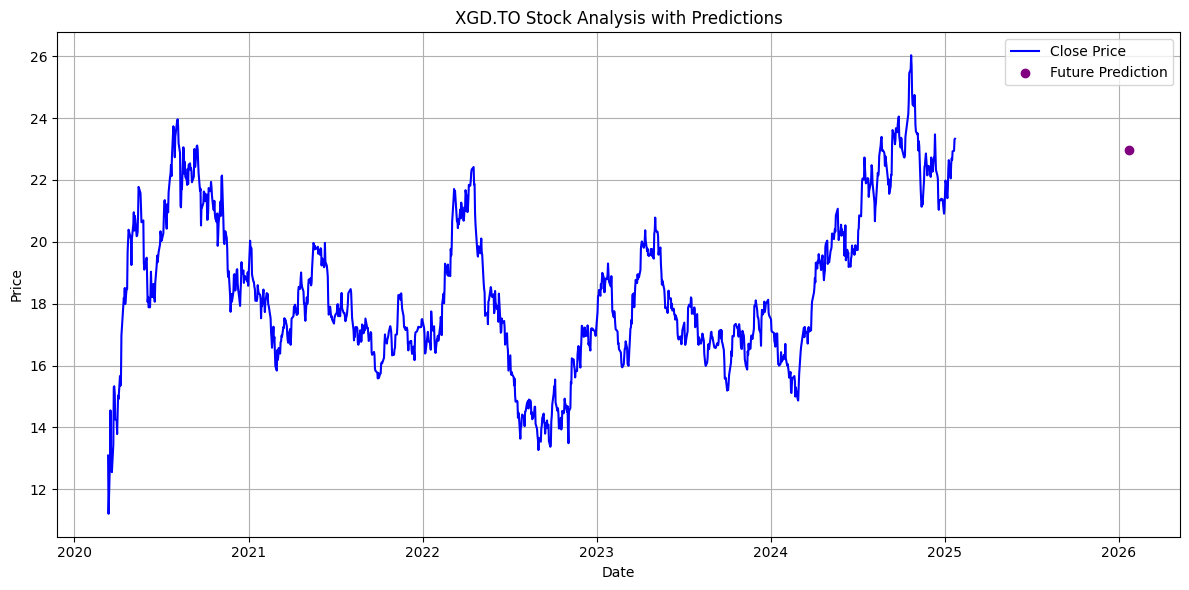

In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Collect inputs from the user
stock_symbol = input("Enter the stock symbol (e.g., AAPL, TD.TO): ").upper()
number_of_shares = float(input("Enter the number of shares you own: "))
purchase_price = float(input("Enter the price at which you bought the stock: "))
investment_period = input("Enter the period you want to analyze (e.g., 3 months, 1 year): ")

# Fetch stock data
data = yf.download(stock_symbol, start="2020-01-01", end="2025-01-23")

# Reset the index to ensure 'Date' is a column
data.reset_index(inplace=True)

# Flatten multi-level column names
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

# Feature Engineering
data['20_MA'] = data['Close_' + stock_symbol].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close_' + stock_symbol].rolling(window=50).mean()  # 50-day moving average
data['Daily_Return'] = data['Close_' + stock_symbol].pct_change()  # Daily percentage return

# Drop rows with NaN values (from rolling windows)
data = data.dropna(subset=['20_MA', '50_MA', 'Daily_Return'])

# Ensure the latest values are properly extracted
latest_close = data['Close_' + stock_symbol].iloc[-1]
latest_20_ma = data['20_MA'].iloc[-1]
latest_50_ma = data['50_MA'].iloc[-1]

# Calculate portfolio value and gain/loss
portfolio_value = number_of_shares * latest_close
total_investment = number_of_shares * purchase_price
gain_loss = portfolio_value - total_investment
gain_loss_percentage = (gain_loss / total_investment) * 100

# Add 'Day' feature
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Define features (X) and target (y)
X = data[['Day', '20_MA', '50_MA', 'Daily_Return']]
y = data['Close_' + stock_symbol]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
print("\nModel Performance:")
print("Model R² score (train):", model.score(X_train, y_train))
print("Model R² score (test):", model.score(X_test, y_test))

# Convert investment period into days
if "month" in investment_period.lower():
    months = int(investment_period.split()[0])
    future_days = months * 30
elif "year" in investment_period.lower():
    years = int(investment_period.split()[0])
    future_days = years * 365
else:
    print("Invalid period. Please enter in months or years.")
    exit()

# Prepare prediction data
future_day = pd.DataFrame({
    'Day': [data['Day'].iloc[-1] + future_days],
    '20_MA': [latest_20_ma],
    '50_MA': [latest_50_ma],
    'Daily_Return': [0]  # Assume neutral return for future
})

# Predict future price
future_price = model.predict(future_day)[0]

# Decision logic
if future_price > latest_close * 1.1:
    decision = "BUY"
elif future_price < latest_close * 0.9:
    decision = "SELL"
else:
    decision = "HOLD"

# Print results
print(f"\n===== Analysis for {stock_symbol} =====")
print(f"Latest Closing Price: ${latest_close:.2f}")
print(f"20-Day Moving Average: ${latest_20_ma:.2f}")
print(f"50-Day Moving Average: ${latest_50_ma:.2f}")
print(f"Your Total Investment: ${total_investment:.2f}")
print(f"Your Portfolio Value: ${portfolio_value:.2f}")
print(f"Your Gain/Loss: ${gain_loss:.2f} ({gain_loss_percentage:.2f}%)")
print(f"Predicted Price for {investment_period}: ${future_price:.2f}")
print(f"Recommendation: {decision}")

# Plot historical prices and predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close_' + stock_symbol], label='Close Price', color='blue')
plt.scatter([data['Date'].iloc[-1] + pd.Timedelta(days=future_days)], [future_price],
            color='purple', label='Future Prediction')
plt.title(f"{stock_symbol} Stock Analysis with Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Enter the stock symbol (e.g., AAPL, TD.TO): xgd.to
Enter the number of shares you own: 20
Enter the price at which you bought the stock: 22.90
Enter the period you want to analyze (e.g., 10 days, 3 months, 1 year): 1 day


[*********************100%***********************]  1 of 1 completed



Model Performance:
Model R² score (train): 0.9941202525786627
Model R² score (test): 0.9616082433783424

===== Analysis for XGD.TO =====
Latest Closing Price: $23.29
20-Day Moving Average: $22.25
50-Day Moving Average: $22.20
Your Total Investment: $458.00
Your Portfolio Value: $465.80
Your Gain/Loss: $7.80 (1.70%)
Predicted Price for 1 day: $23.10
Recommendation: HOLD


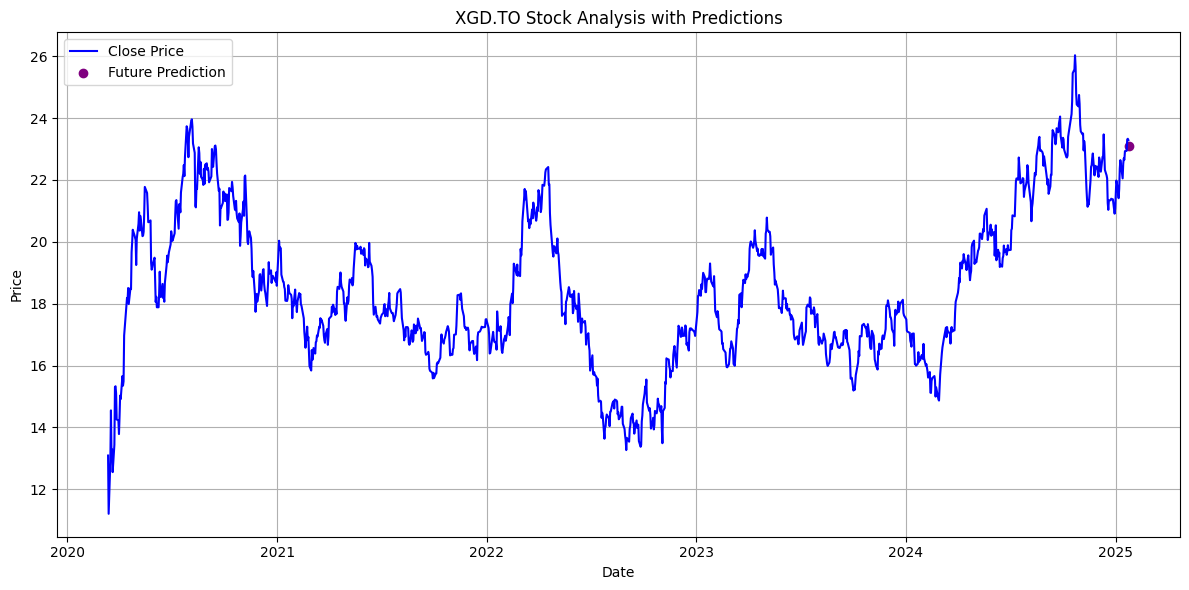

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Collect inputs from the user
stock_symbol = input("Enter the stock symbol (e.g., AAPL, TD.TO): ").upper()
number_of_shares = float(input("Enter the number of shares you own: "))
purchase_price = float(input("Enter the price at which you bought the stock: "))
investment_period = input("Enter the period you want to analyze (e.g., 10 days, 3 months, 1 year): ")

# Fetch stock data (from 2020-01-01 to today)
data = yf.download(stock_symbol, start="2020-01-01", end=today_date)

# Reset the index to ensure 'Date' is a column
data.reset_index(inplace=True)

# Flatten multi-level column names
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

# Feature Engineering
data['20_MA'] = data['Close_' + stock_symbol].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close_' + stock_symbol].rolling(window=50).mean()  # 50-day moving average
data['Daily_Return'] = data['Close_' + stock_symbol].pct_change()  # Daily percentage return

# Drop rows with NaN values (from rolling windows)
data = data.dropna(subset=['20_MA', '50_MA', 'Daily_Return'])

# Ensure the latest values are properly extracted
latest_close = data['Close_' + stock_symbol].iloc[-1]
latest_20_ma = data['20_MA'].iloc[-1]
latest_50_ma = data['50_MA'].iloc[-1]

# Calculate portfolio value and gain/loss
portfolio_value = number_of_shares * latest_close
total_investment = number_of_shares * purchase_price
gain_loss = portfolio_value - total_investment
gain_loss_percentage = (gain_loss / total_investment) * 100

# Add 'Day' feature
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Define features (X) and target (y)
X = data[['Day', '20_MA', '50_MA', 'Daily_Return']]
y = data['Close_' + stock_symbol]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
print("\nModel Performance:")
print("Model R² score (train):", model.score(X_train, y_train))
print("Model R² score (test):", model.score(X_test, y_test))

# Convert investment period into days
if "day" in investment_period.lower():
    days = int(investment_period.split()[0])
    future_days = days
elif "month" in investment_period.lower():
    months = int(investment_period.split()[0])
    future_days = months * 30
elif "year" in investment_period.lower():
    years = int(investment_period.split()[0])
    future_days = years * 365
else:
    print("Invalid period. Please enter in days, months, or years.")
    exit()

# Prepare prediction data
future_day = pd.DataFrame({
    'Day': [data['Day'].iloc[-1] + future_days],
    '20_MA': [latest_20_ma],
    '50_MA': [latest_50_ma],
    'Daily_Return': [0]  # Assume neutral return for future
})

# Predict future price
future_price = model.predict(future_day)[0]

# Decision logic
if future_price > latest_close * 1.1:
    decision = "BUY"
elif future_price < latest_close * 0.9:
    decision = "SELL"
else:
    decision = "HOLD"

# Print results
print(f"\n===== Analysis for {stock_symbol} =====")
print(f"Latest Closing Price: ${latest_close:.2f}")
print(f"20-Day Moving Average: ${latest_20_ma:.2f}")
print(f"50-Day Moving Average: ${latest_50_ma:.2f}")
print(f"Your Total Investment: ${total_investment:.2f}")
print(f"Your Portfolio Value: ${portfolio_value:.2f}")
print(f"Your Gain/Loss: ${gain_loss:.2f} ({gain_loss_percentage:.2f}%)")
print(f"Predicted Price for {investment_period}: ${future_price:.2f}")
print(f"Recommendation: {decision}")

# Plot historical prices and predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close_' + stock_symbol], label='Close Price', color='blue')
plt.scatter([data['Date'].iloc[-1] + pd.Timedelta(days=future_days)], [future_price],
            color='purple', label='Future Prediction')
plt.title(f"{stock_symbol} Stock Analysis with Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Enter the stock symbol (e.g., AAPL, TD.TO): TD.to
Enter the number of shares you own: 1
Enter the price at which you bought the stock: 74.27
Enter the future date you want to analyze (YYYY-MM-DD): 2025-01-25
Please enter a future date.


[*********************100%***********************]  1 of 1 completed



Model Performance:
Model R² score (train): 0.9986547805960238
Model R² score (test): 0.9914848562690487

===== Analysis for TD.TO =====
Latest Closing Price: $82.23
20-Day Moving Average: $78.35
50-Day Moving Average: $77.01
Your Total Investment: $74.27
Your Portfolio Value: $82.23
Your Gain/Loss: $7.96 (10.72%)
Predicted Price for 2025-01-25: $81.87
Recommendation: HOLD


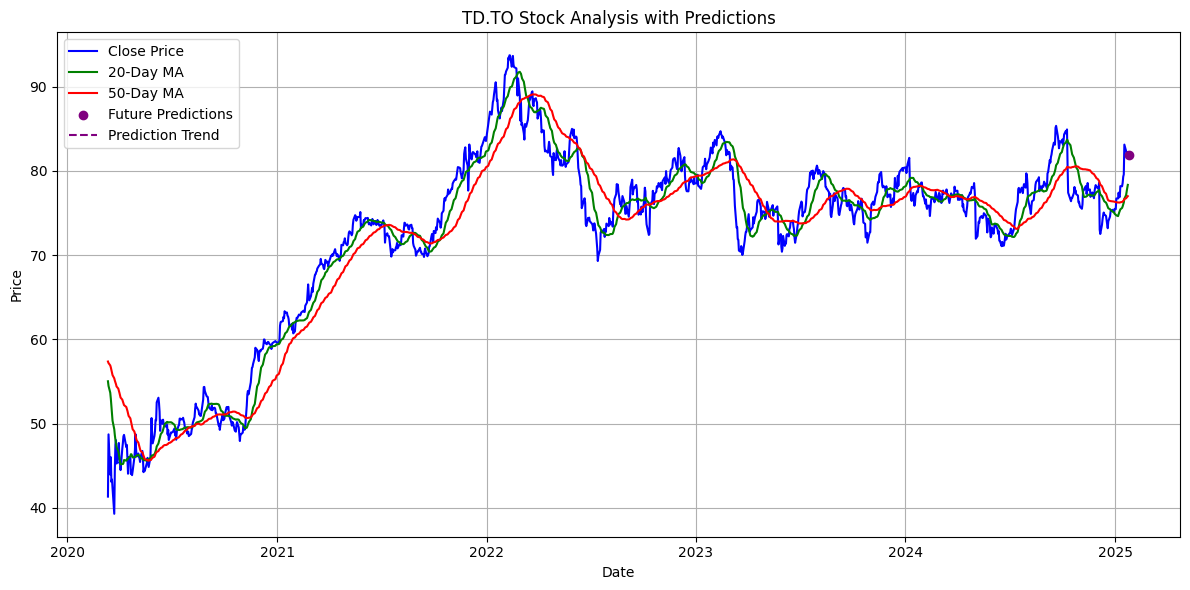

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Collect inputs from the user
stock_symbol = input("Enter the stock symbol (e.g., AAPL, TD.TO): ").upper()
number_of_shares = float(input("Enter the number of shares you own: "))
purchase_price = float(input("Enter the price at which you bought the stock: "))
custom_date = input("Enter the future date you want to analyze (YYYY-MM-DD): ")

# Validate custom date
try:
    future_date = datetime.strptime(custom_date, '%Y-%m-%d')
    days_difference = (future_date - datetime.today()).days
    if days_difference <= 0:
        print("Please enter a future date.")
        exit()
except ValueError:
    print("Invalid date format. Please enter in YYYY-MM-DD format.")
    exit()

# Fetch stock data (from 2020-01-01 to today)
data = yf.download(stock_symbol, start="2020-01-01", end=today_date)

# Reset the index to ensure 'Date' is a column
data.reset_index(inplace=True)

# Flatten multi-level column names
data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

# Feature Engineering
data['20_MA'] = data['Close_' + stock_symbol].rolling(window=20).mean()  # 20-day moving average
data['50_MA'] = data['Close_' + stock_symbol].rolling(window=50).mean()  # 50-day moving average
data['Daily_Return'] = data['Close_' + stock_symbol].pct_change()  # Daily percentage return

# Drop rows with NaN values (from rolling windows)
data = data.dropna(subset=['20_MA', '50_MA', 'Daily_Return'])

# Ensure the latest values are properly extracted
latest_close = data['Close_' + stock_symbol].iloc[-1]
latest_20_ma = data['20_MA'].iloc[-1]
latest_50_ma = data['50_MA'].iloc[-1]

# Calculate portfolio value and gain/loss
portfolio_value = number_of_shares * latest_close
total_investment = number_of_shares * purchase_price
gain_loss = portfolio_value - total_investment
gain_loss_percentage = (gain_loss / total_investment) * 100

# Add 'Day' feature
data['Day'] = (data['Date'] - data['Date'].min()).dt.days

# Define features (X) and target (y)
X = data[['Day', '20_MA', '50_MA', 'Daily_Return']]
y = data['Close_' + stock_symbol]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
print("\nModel Performance:")
print("Model R² score (train):", model.score(X_train, y_train))
print("Model R² score (test):", model.score(X_test, y_test))

# Prepare prediction data
future_day = pd.DataFrame({
    'Day': [data['Day'].iloc[-1] + days_difference],
    '20_MA': [latest_20_ma],
    '50_MA': [latest_50_ma],
    'Daily_Return': [0]  # Assume neutral return for future
})

# Predict future price
future_price = model.predict(future_day)[0]

# Decision logic
if future_price > latest_close * 1.1:
    decision = "BUY"
elif future_price < latest_close * 0.9:
    decision = "SELL"
else:
    decision = "HOLD"

# Print results
print(f"\n===== Analysis for {stock_symbol} =====")
print(f"Latest Closing Price: ${latest_close:.2f}")
print(f"20-Day Moving Average: ${latest_20_ma:.2f}")
print(f"50-Day Moving Average: ${latest_50_ma:.2f}")
print(f"Your Total Investment: ${total_investment:.2f}")
print(f"Your Portfolio Value: ${portfolio_value:.2f}")
print(f"Your Gain/Loss: ${gain_loss:.2f} ({gain_loss_percentage:.2f}%)")
print(f"Predicted Price for {custom_date}: ${future_price:.2f}")
print(f"Recommendation: {decision}")

# Plot historical prices and predictions
plt.figure(figsize=(12, 6))

# Historical Prices
plt.plot(data['Date'], data['Close_' + stock_symbol], label='Close Price', color='blue')

# Moving Averages
plt.plot(data['Date'], data['20_MA'], label='20-Day MA', color='green')
plt.plot(data['Date'], data['50_MA'], label='50-Day MA', color='red')

# Future Prediction
plt.scatter([future_date], [future_price], color='purple', label="Future Predictions", zorder=5)
plt.plot([data['Date'].iloc[-1], future_date],
         [latest_close, future_price],
         color='purple', linestyle='--', label="Prediction Trend")

# Customize the graph
plt.title(f"{stock_symbol} Stock Analysis with Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.tight_layout()

# Show the graph
plt.show()


Fetching data for TD.TO...


[*********************100%***********************]  1 of 1 completed



Model Performance:
Model R² score (train): 0.9986523605473611
Model R² score (test): 0.9914728648947374

===== Analysis for TD.TO =====
Latest Closing Price: $82.23
20-Day Moving Average: $78.35
50-Day Moving Average: $77.01
Your Total Investment: $519.89
Your Portfolio Value: $575.61
Your Gain/Loss: $55.72 (10.72%)
Predicted Price for 2025-04-25: $81.85
Recommendation: HOLD


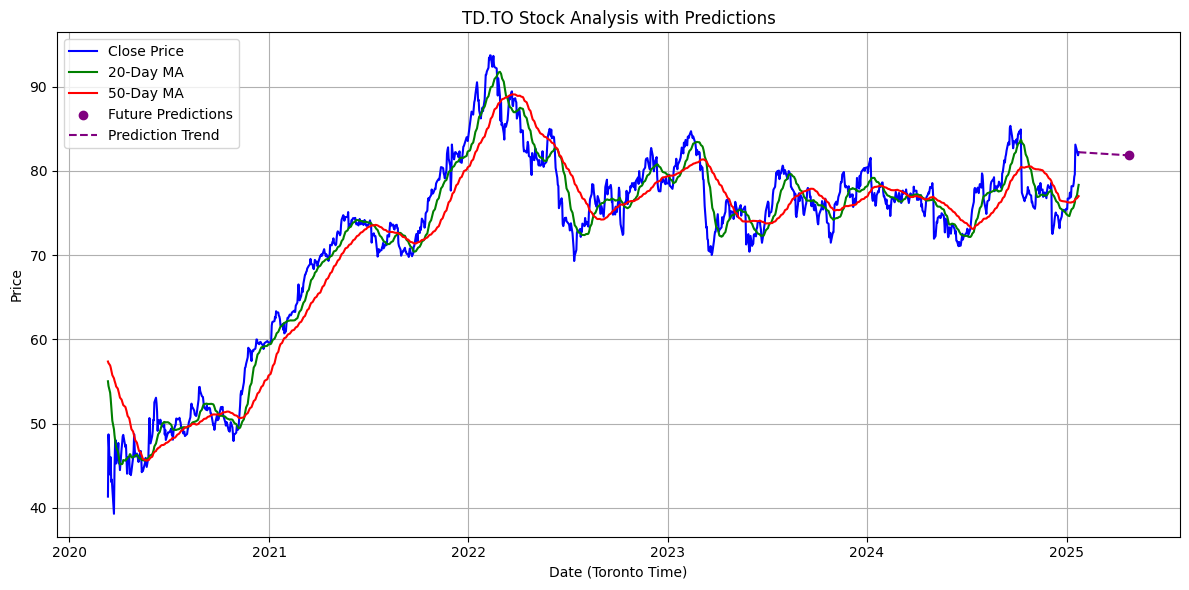

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import pytz

# Set Toronto timezone
toronto_tz = pytz.timezone("America/Toronto")

def analyze_stock():
    try:
        # Get today's date in Toronto timezone
        today_date = datetime.now(toronto_tz).strftime('%Y-%m-%d')

        # Collect inputs from the user
        stock_symbol = input("Enter the stock symbol (e.g., AAPL, TD.TO): ").upper()
        number_of_shares = float(input("Enter the number of shares you own: "))
        purchase_price = float(input("Enter the price at which you bought the stock: "))
        custom_date = input("Enter the future date you want to analyze (YYYY-MM-DD): ")

        # Validate custom date
        try:
            # Convert user-entered date to timezone-aware datetime
            future_date = toronto_tz.localize(datetime.strptime(custom_date, '%Y-%m-%d'))
            current_date = datetime.now(toronto_tz)
            days_difference = (future_date - current_date).days
            if days_difference <= 0:
                print("Error: Please enter a future date.")
                return
        except ValueError:
            print("Error: Invalid date format. Please enter in YYYY-MM-DD format.")
            return

        # Fetch stock data
        print(f"Fetching data for {stock_symbol}...")
        data = yf.download(stock_symbol, start="2020-01-01", end=today_date)
        if data.empty:
            print(f"Error: No data found for stock symbol '{stock_symbol}'. Please try again.")
            return

        # Reset the index to ensure 'Date' is a column
        data.reset_index(inplace=True)

        # Adjust the 'Date' column to Toronto timezone
        data['Date'] = data['Date'].dt.tz_localize('UTC').dt.tz_convert(toronto_tz)

        # Flatten multi-level column names
        data.columns = ['_'.join(filter(None, col)).strip() for col in data.columns]

        # Feature Engineering
        data['20_MA'] = data['Close_' + stock_symbol].rolling(window=20).mean()  # 20-day moving average
        data['50_MA'] = data['Close_' + stock_symbol].rolling(window=50).mean()  # 50-day moving average
        data['Daily_Return'] = data['Close_' + stock_symbol].pct_change()  # Daily percentage return

        # Drop rows with NaN values (from rolling windows)
        data = data.dropna(subset=['20_MA', '50_MA', 'Daily_Return'])

        # Ensure the latest values are properly extracted
        latest_close = data['Close_' + stock_symbol].iloc[-1]
        latest_20_ma = data['20_MA'].iloc[-1]
        latest_50_ma = data['50_MA'].iloc[-1]

        # Calculate portfolio value and gain/loss
        portfolio_value = number_of_shares * latest_close
        total_investment = number_of_shares * purchase_price
        gain_loss = portfolio_value - total_investment
        gain_loss_percentage = (gain_loss / total_investment) * 100

        # Add 'Day' feature
        data['Day'] = (data['Date'] - data['Date'].min()).dt.days

        # Define features (X) and target (y)
        X = data[['Day', '20_MA', '50_MA', 'Daily_Return']]
        y = data['Close_' + stock_symbol]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train a Random Forest model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate model
        print("\nModel Performance:")
        print("Model R² score (train):", model.score(X_train, y_train))
        print("Model R² score (test):", model.score(X_test, y_test))

        # Prepare prediction data
        future_day = pd.DataFrame({
            'Day': [data['Day'].iloc[-1] + days_difference],
            '20_MA': [latest_20_ma],
            '50_MA': [latest_50_ma],
            'Daily_Return': [0]  # Assume neutral return for future
        })

        # Predict future price
        future_price = model.predict(future_day)[0]

        # Decision logic
        if future_price > latest_close * 1.1:
            decision = "BUY"
        elif future_price < latest_close * 0.9:
            decision = "SELL"
        else:
            decision = "HOLD"

        # Print results
        print(f"\n===== Analysis for {stock_symbol} =====")
        print(f"Latest Closing Price: ${latest_close:.2f}")
        print(f"20-Day Moving Average: ${latest_20_ma:.2f}")
        print(f"50-Day Moving Average: ${latest_50_ma:.2f}")
        print(f"Your Total Investment: ${total_investment:.2f}")
        print(f"Your Portfolio Value: ${portfolio_value:.2f}")
        print(f"Your Gain/Loss: ${gain_loss:.2f} ({gain_loss_percentage:.2f}%)")
        print(f"Predicted Price for {custom_date}: ${future_price:.2f}")
        print(f"Recommendation: {decision}")

        # Plot historical prices and predictions
        plt.figure(figsize=(12, 6))

        # Historical Prices
        plt.plot(data['Date'], data['Close_' + stock_symbol], label='Close Price', color='blue')

        # Moving Averages
        plt.plot(data['Date'], data['20_MA'], label='20-Day MA', color='green')
        plt.plot(data['Date'], data['50_MA'], label='50-Day MA', color='red')

        # Future Prediction
        plt.scatter([future_date], [future_price], color='purple', label="Future Predictions", zorder=5)
        plt.plot([data['Date'].iloc[-1], future_date],
                 [latest_close, future_price],
                 color='purple', linestyle='--', label="Prediction Trend")

        # Customize the graph
        plt.title(f"{stock_symbol} Stock Analysis with Predictions")
        plt.xlabel("Date (Toronto Time)")
        plt.ylabel("Price")
        plt.legend()
        plt.grid()
        plt.tight_layout()

        # Show the graph
        plt.show()

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Keep running the program until the user wants to stop
while True:
    analyze_stock()
    user_choice = input("Do you want to analyze another stock? (yes/no): ").strip().lower()
    if user_choice == "no":
        print("Exiting the program. Thank you!")
        break
7